In [270]:
import pandas as pd
import pymc as pm
import arviz as az
import scipy
import seaborn as sns
import numpy as np

df = pd.read_csv('./data/fm_data.csv')
df = df[df['TYPE'] == 'Standard (1-way)'].reset_index(drop=True)
df.columns

Index(['team', 'merge_name', 'season', 'playerId', 'name', 'position',
       'games_played', 'icetime', 'faceoffsWon', 'penalityMinutes',
       'shotsBlockedByPlayer', 'I_F_points', 'I_F_dZoneGiveaways', 'I_F_hits',
       'AGE', 'TYPE', 'EXTENSION', 'SIGNING AGE', 'LENGTH', 'SALARY', 'Team',
       'State/Prov', 'Country', 'Conference', 'Division', 'O6', 'EffTaxRate',
       'L_Salary', 'xGoals_diff', 'faceoffsWon_per60', 'penalityMinutes_per60',
       'shotsBlockedByPlayer_per60', 'I_F_points_per60',
       'I_F_dZoneGiveaways_per60', 'I_F_hits_per60', 'xGoals_diff_per60'],
      dtype='object')

<Axes: ylabel='Count'>

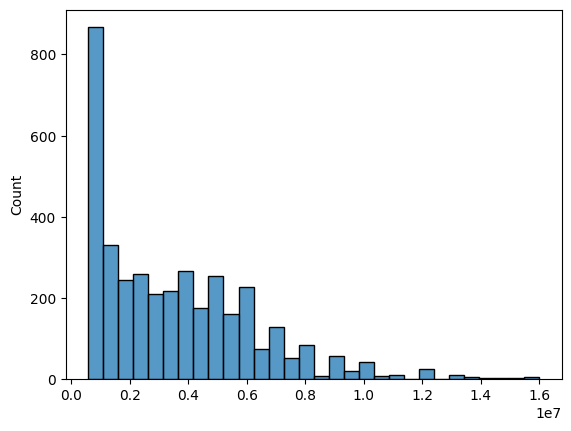

In [37]:
# sns.histplot(boxcox(df['L_Salary'], 3))

sns.histplot(np.exp(scipy.special.inv_boxcox(scipy.stats.boxcox(df['L_Salary'], 3), 3)))


In [104]:
categorical_indices = {}
player_indices = {}

player_stat_columns = [
    'xGoals_diff', 'penalityMinutes_per60', 'shotsBlockedByPlayer_per60', 
    'I_F_points_per60', 'I_F_dZoneGiveaways_per60', 'I_F_hits_per60'
]

county_columns = ['EffTaxRate']

# df['team'].factorize()
for var in ['name', 'team', 'position']:
    player_cat_index, cat_values = df[var].factorize()
    categorical_indices.update({var: cat_values.values})
    player_indices.update({var: player_cat_index})

# 
coords = categorical_indices
coords.update({'player_stats': player_stat_columns})


In [105]:

categorical_uniques = pd.DataFrame(player_indices).merge(df['EffTaxRate'].reset_index(drop=True), left_index=True, right_index=True)
cdf = categorical_uniques[['team', 'EffTaxRate']].drop_duplicates()
cdf.head()


,team,EffTaxRate
0,0,0.466
129,1,0.412
237,2,0.415
370,3,0.432
496,4,0.420


In [110]:
import numpy as np
X = df[player_stat_columns].values

# name, team, position
p_idx = pd.DataFrame(player_indices).values
p_idx


array([[  0,   0,   0],
       [  1,   0,   1],
       [  1,   0,   1],
       ...,
       [264,  31,   2],
       [264,  31,   2],
       [999,  31,   1]])

In [164]:
with pm.Model(coords=coords) as model:
    stats = pm.Data('X', X, mutable=True)
    p_groups = pm.Data('p_idx', p_idx, mutable=True)
    log_salary = pm.Data('obs_log_salary', df['L_Salary'].values, mutable=True)

    global_salary = pm.Normal('global_salary', 14, 2)
    global_salary_exp = pm.Deterministic('global_salary_exp', np.exp(global_salary))
    team_sigma = pm.HalfNormal('team_sigma', 1)

    # remove because they have almost no impact and are highly correlated
    # country_beta = pm.Normal('country_beta', 0, 5, dims='Country')
    # o6_beta = pm.Normal('o6_beta', 0, 5, dims='O6')
    tax_beta = pm.Normal('tax_beta', 0, 5)

    intercept = pm.Deterministic('intercept', global_salary + tax_beta * cdf['EffTaxRate'].values, dims='team') 
    team_offset = pm.Normal('team_offset', 0, 2, dims='team')
    team_intercept = pm.Deterministic('team_intercept', intercept + team_offset*team_sigma, dims='team')
    team_intercept_exp = pm.Deterministic('team_intercept_exp', np.exp(team_intercept), dims='team')
    
    player_stats_global = pm.Laplace('player_stats_global', 0, 10, dims='player_stats')
    player_stats_sigma = pm.HalfNormal('player_position_sigma', 2, dims='player_stats')

    position_za = pm.Laplace("za_position", 0.0, 10, dims=("position", "player_stats")) 
    player_stats_position = pm.Deterministic('player_stats_position', player_stats_global + position_za * player_stats_sigma, dims=['position', 'player_stats'])

    contract_mu = team_intercept[p_groups[:,1]] + (stats * player_stats_position[p_groups[:, 2]]).sum(axis=1)

    salary_sigma = pm.HalfCauchy('salary_sigma', 5)
    y = pm.Cauchy('log_salary', contract_mu, salary_sigma, observed = log_salary)



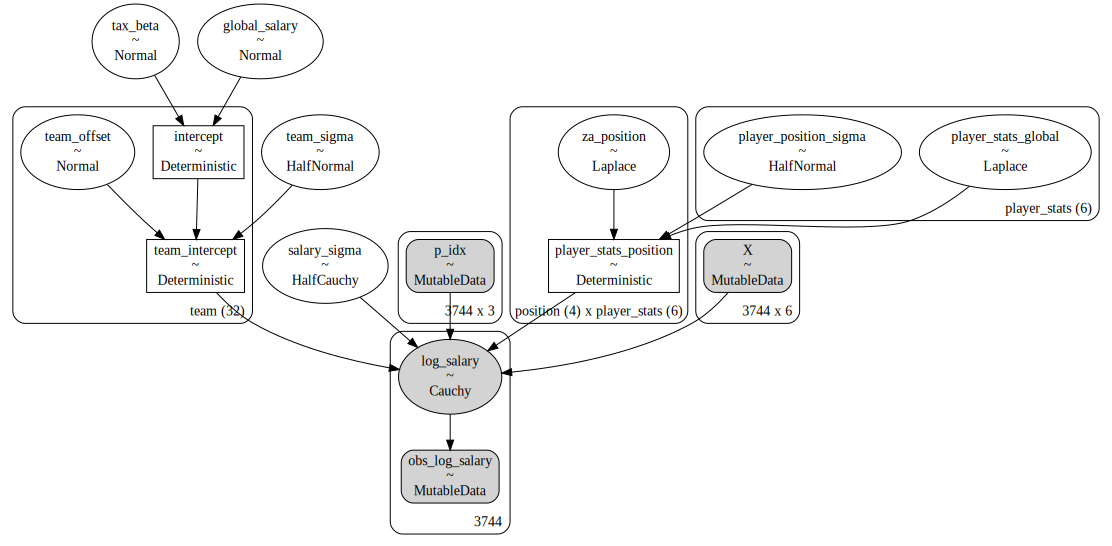

In [170]:
m = pm.model_to_graphviz(model, var_names=[rv.name for rv in model.basic_RVs])
m
# m.format = 'png'
# m.render(filename='model')

In [171]:
with model:
    trace = pm.sample(1000, target_accept=0.975)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_salary, team_sigma, tax_beta, team_offset, player_stats_global, player_position_sigma, za_position, salary_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 392 seconds.


['xGoals_diff', 'penalityMinutes_per60', 'shotsBlockedByPlayer_per60', 'I_F_points_per60', 'I_F_dZoneGiveaways_per60', 'I_F_hits_per60']


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

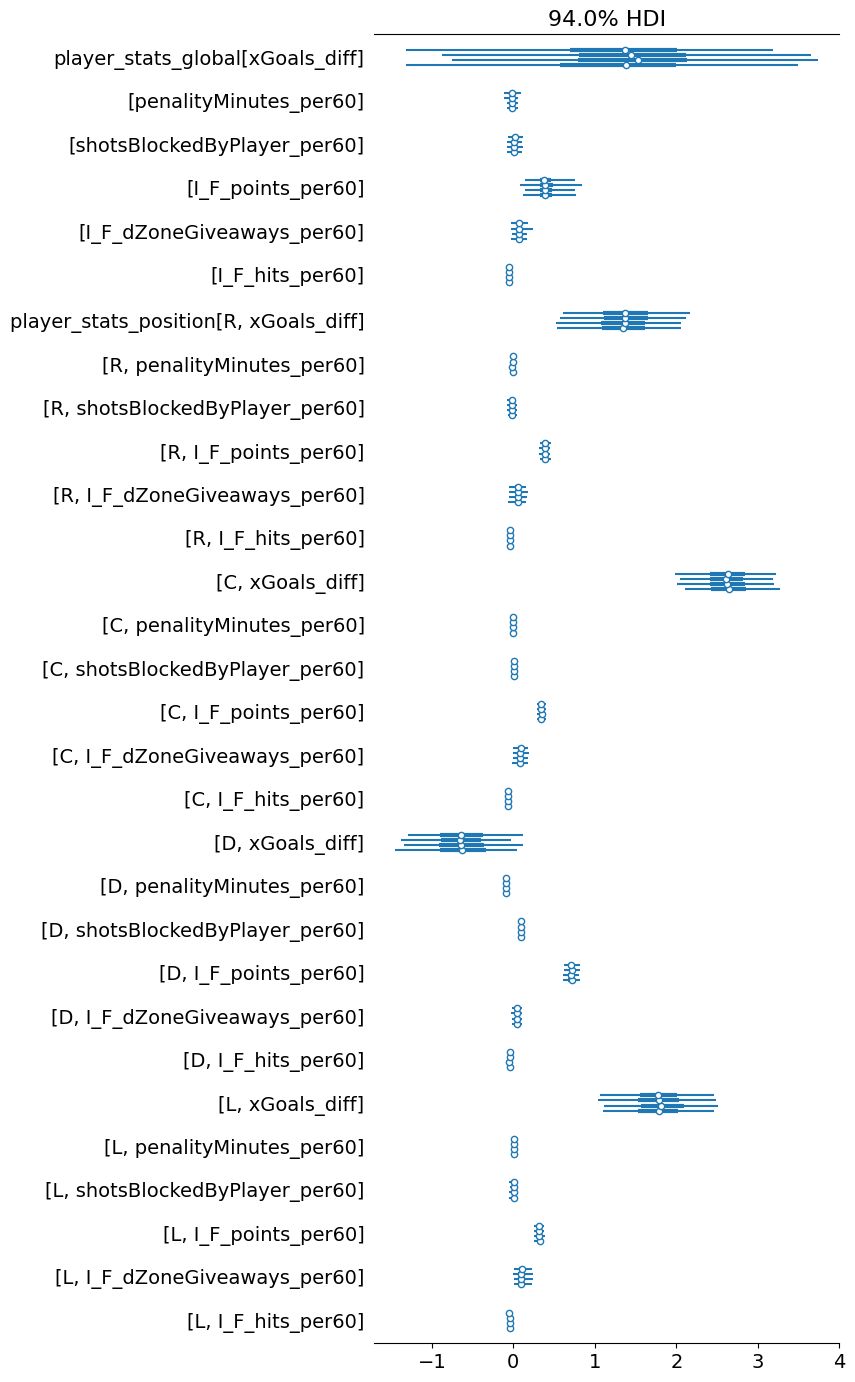

In [295]:
# trace.to_json(filename='output_posterior.json')
print(player_stat_columns)
az.plot_forest(trace, var_names=['player_stats_global', 'player_stats_position'], coords = {})

In [306]:
az.summary(trace, var_names=['global_salary_exp', 'team_intercept_exp'])[['mean', 'hdi_3%', 'hdi_97%', 'ess_bulk', 'r_hat']].to_csv('team_intercepts.csv')

In [323]:
coeff_out = az.summary(
    trace, 
    var_names=['tax_beta', 'player_stats_position'], 
    coords={'player_stats': ['shotsBlockedByPlayer_per60', 'I_F_points_per60', 'I_F_hits_per60']}
)[['mean', 'hdi_3%', 'hdi_97%', 'ess_bulk', 'r_hat']].sort_index(ascending=False)

coeff_out.to_csv('coefficients_of_interest.csv')

array([[<Axes: title={'center': 'global_salary_exp'}>,
        <Axes: title={'center': 'global_salary_exp'}>],
       [<Axes: title={'center': 'tax_beta'}>,
        <Axes: title={'center': 'tax_beta'}>],
       [<Axes: title={'center': 'team_intercept_exp'}>,
        <Axes: title={'center': 'team_intercept_exp'}>],
       [<Axes: title={'center': 'player_stats_global'}>,
        <Axes: title={'center': 'player_stats_global'}>],
       [<Axes: title={'center': 'player_stats_position'}>,
        <Axes: title={'center': 'player_stats_position'}>]], dtype=object)

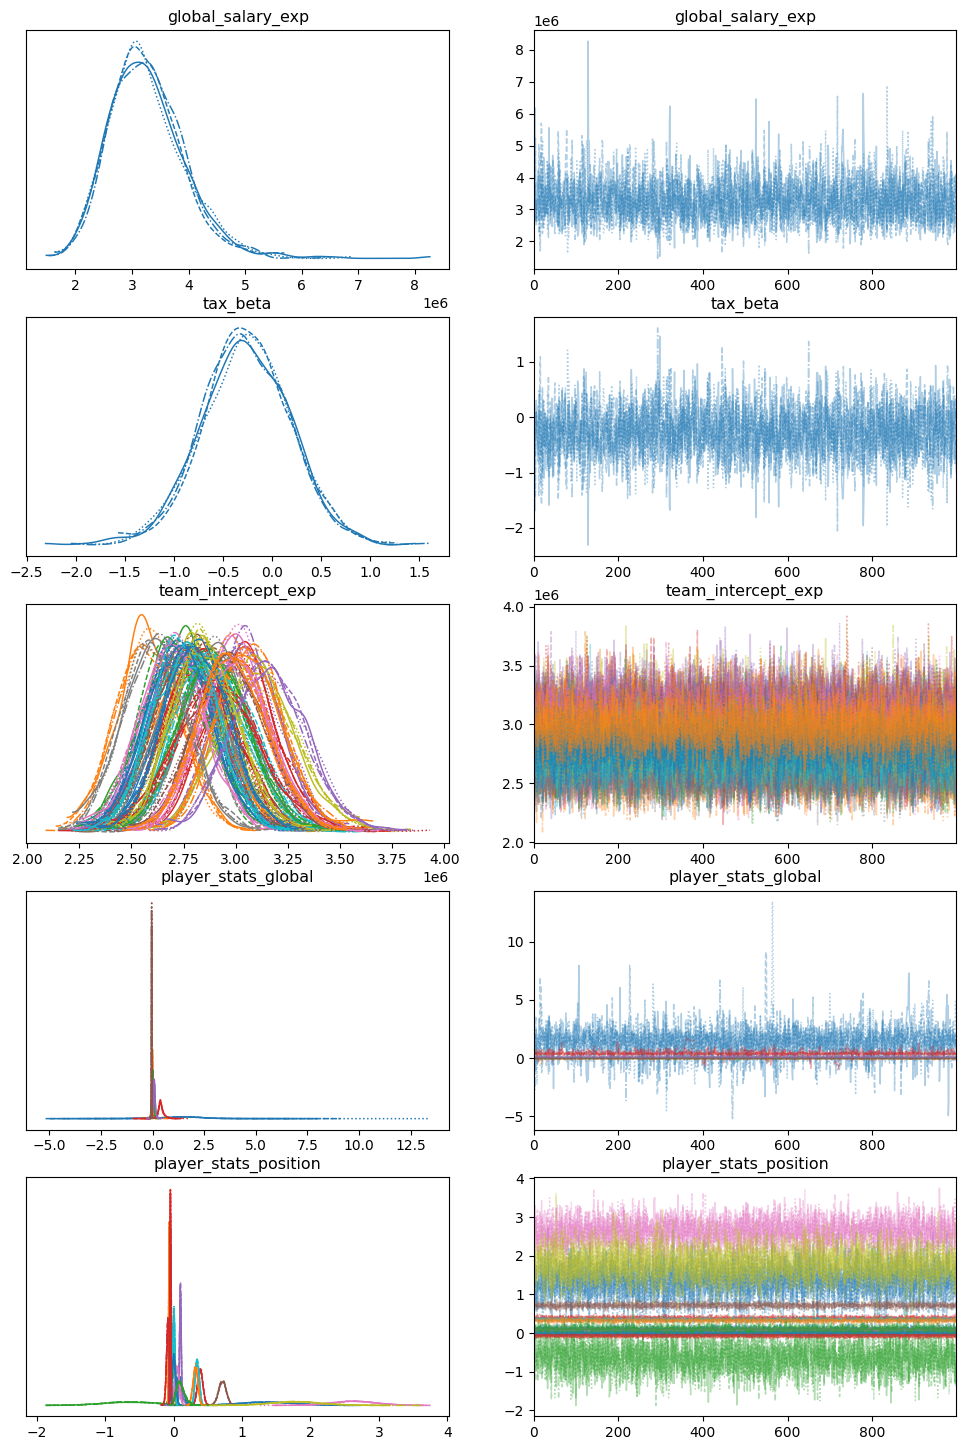

In [173]:
az.plot_trace(trace, figsize=(12, 18), divergences=False, var_names=['global_salary_exp', 'tax_beta', 'team_intercept_exp', 'player_stats_global', 'player_stats_position'])

['xGoals_diff', 'penalityMinutes_per60', 'shotsBlockedByPlayer_per60', 'I_F_points_per60', 'I_F_dZoneGiveaways_per60', 'I_F_hits_per60']


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

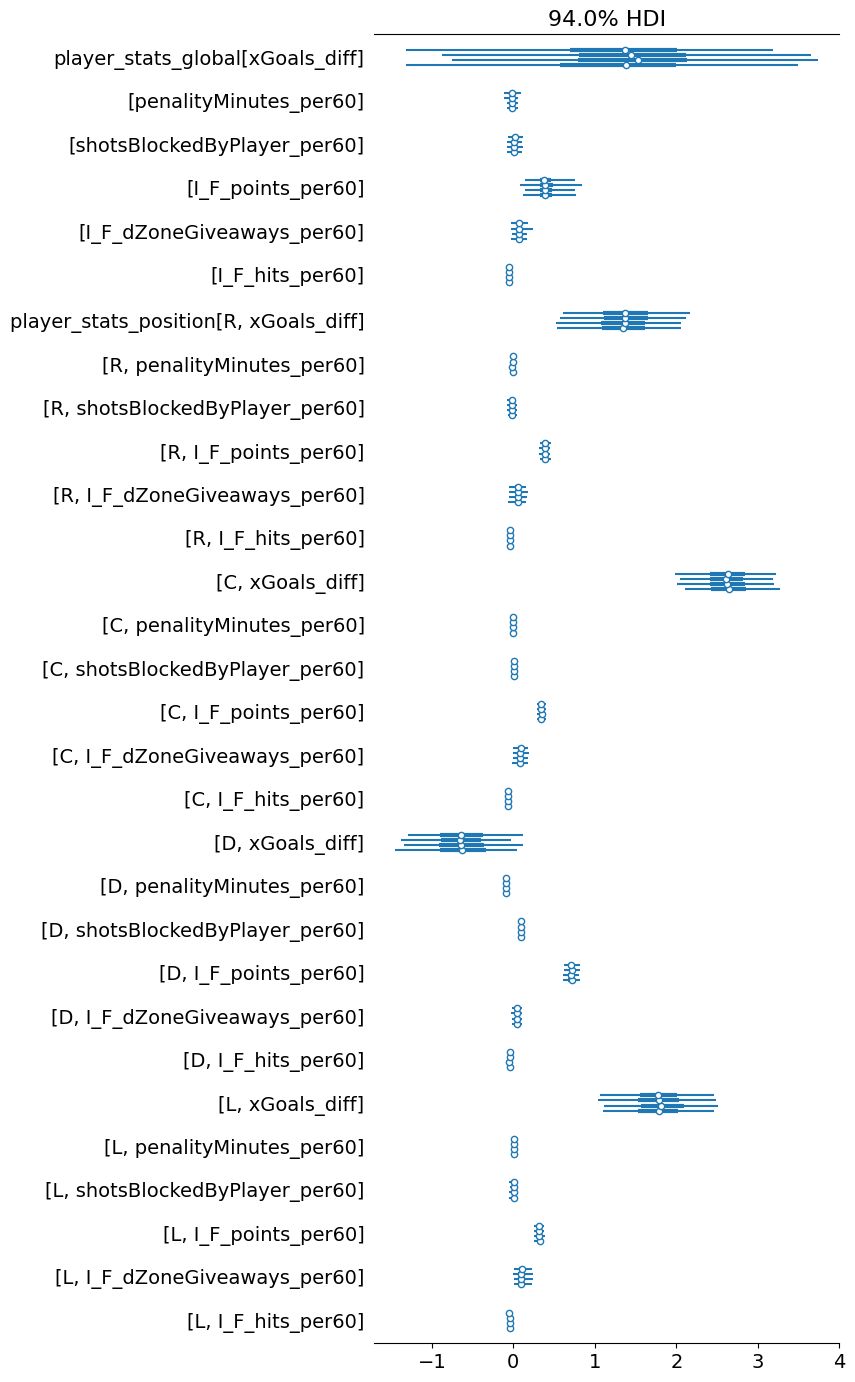

In [174]:
# az.plot_forest(trace, coords={'TYPE': 'Standard (1-way)', 'position': ['L']}, var_names=['team_salary'])
print(player_stat_columns)
az.plot_forest(trace, var_names=['player_stats_global', 'player_stats_position'], coords = {})

In [175]:
# odd file format, but useful for reloading the model later
az.summary(trace, var_names=['global_salary_exp', 'team_intercept_exp', 'tax_beta', 'player_stats_global', 'player_stats_position']).to_csv('trace_output.csv')
trace.to_netcdf('output_trace.nc')

'output_trace.json'

In [292]:
# From here downward, this is toy code for looking at individual players
# and predicting their salary on other teams. Our model has very high variance.
idx = df[(df['name'] == 'Morgan Frost') & (df['season'] == 2022)].index.values[0]
player_name = df.iloc[idx]['name']
print(player_name)
test_x = X[idx, :]

X_pred = np.array([test_x for _ in range(32)])
p_idx_pred = np.array([p_idx[idx, :].squeeze() for _ in range(32)])
p_idx_pred[:, 1] = list(range(32))


Morgan Frost


In [293]:
with model:
    model.set_data('X', values = X_pred)
    model.set_data('p_idx', values = p_idx_pred)
    model.set_data('obs_log_salary', values=np.array(range(32)))
    preds = pm.sample_posterior_predictive(trace)

In [294]:
output_prediction = preds.posterior_predictive.quantile(dim=['chain', 'draw'], q=[0.1, 0.5, 0.9]).to_dataframe().reset_index()
output_prediction.columns = ['team', 'quantile', 'salary']
salary_preds = output_prediction.pivot(index='team', columns='quantile', values='salary').apply(np.exp).apply(lambda x: np.round(x, -3)).astype(int).reset_index(drop=True)
salary_preds['team'] = coords['team']
salary_preds = salary_preds.set_index('team')
print(f'Player: {player_name}')
salary_preds


Player: Morgan Frost


quantile,0.1,0.5,0.9
team,,,
ANA,938000,3403000,12294000
ARI,931000,3393000,12168000
BOS,1015000,3324000,11639000
BUF,1075000,3640000,11736000
CAR,1039000,3727000,12296000
CBJ,971000,3467000,11979000
CGY,1029000,3623000,11651000
CHI,984000,3361000,11689000
COL,901000,3466000,12993000
